### Load Movies DataSet

In [2]:
# %load load-movies.py
import pandas as pd

movies = pd.read_csv('./data/tmdb_5000_movies.csv')
credits = pd.read_csv('./data/tmdb_5000_credits.csv')

### Clean Data

In [3]:
# %load clean-movies.py
import pandas as pd
import numpy as np
import sklearn as sk
import json

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

# merge two datasets
movies = pd.merge(left=movies, right=credits, left_on='id', right_on='movie_id')

# turn json into python objects
json_columns = ['genres', 'keywords', 'production_countries', 'spoken_languages', 'cast', 'crew']
for column in json_columns:
  movies[column] = movies[column].apply(json.loads, encoding="utf-8")



######## Actors ########

# create functions that will help with extracting actor information
def actor_to_id_string(actor):
  return '{} - {}'.format(actor['name'], actor['id'])

def cast_to_actors(cast):
  actors = []
  for person in cast:
    actors.append(actor_to_id_string(person))
  return actors

# Create a new column (array) from cast
movies.actors = movies.cast.apply(cast_to_actors)

# Create a list of all actors
all_actors = []
for actors in movies.actors:
  for actor in actors:
    all_actors.append(actor)
actors = pd.Series(all_actors)
unique_actors_count = pd.crosstab(actors, columns='count')

# Create function to determine if actor has been in more than 3 films
actors_string_id_by_id = {}
actor_counts_by_string_id = {}
unique_actors_count_dict = unique_actors_count.to_dict()['count']

def actor_has_more_than_x_movies(actor, number_of_movies = 3):
    string_id = str(actor['id'])

    # First, get the unique id created for the actor
    actor_string_id = ''
    if string_id in actors_string_id_by_id:
        actor_string_id = actors_string_id_by_id[string_id]
    else:
        actor_string_id = actor_to_id_string(actor)
        actors_string_id_by_id[string_id] = actor_string_id
    
    # Now let's see how many movies this actor has played in
    actor_count = unique_actors_count_dict[actor_string_id]
    return actor_count > number_of_movies

# Create a list of all actors that have been in more than 3 movies
movies_actors_ids = []
for actors in movies.cast:
  movie_actors_ids = []
  for actor in actors:
    if (not actor_has_more_than_x_movies(actor, 3)):
      continue
    movie_actors_ids.append(str(actor['id']))
  movies_actors_ids.append(' '.join(movie_actors_ids))

# Vectorize the list of actors
def get_actor_feature_name(id):
  return actors_string_id_by_id[id] + ' (actor)'
vectorizer = CountVectorizer()
movie_vector = vectorizer.fit_transform(movies_actors_ids).toarray()

actor_feature_ids = vectorizer.get_feature_names()
actor_feature_names = []
for id in actor_feature_ids:
  actor_name = get_actor_feature_name(id)
  actor_feature_names.append(actor_name)

actor_vector_works = pd.DataFrame(movie_vector, columns=actor_feature_names)
actor_vector_works['id'] = movies.id

# Create the label for whether Samuel L Jackson was in the film (samuel)
movies['samuel'] = actor_vector_works[get_actor_feature_name('2231')] == 1





######## GENRES ########

def unique_genres(movies_genres):
  genre_map = {}
  for genres in movies_genres:
    for genre in genres:
      name = genre['name']
      if not name in genre_map:
        genre_map[name] = 0
      genre_map[name]+=1
  return pd.Series(genre_map).sort_values(ascending=False)

def get_genres_feature_name(genre):
  return genre['name'] + ' (genre)'

movies_genres_ids = []
movie_genres_names_by_id = {}
for genres in movies.genres:
  movie_genres_ids = []
  for genre in genres:
    genre_feature_name = get_genres_feature_name(genre)
    movie_genres_ids.append(str(genre['id']))
    movie_genres_names_by_id[str(genre['id'])] = genre_feature_name
  movies_genres_ids.append(' '.join(movie_genres_ids))

genre_vectorization = CountVectorizer()

movie_vector = genre_vectorization.fit_transform(movies_genres_ids).toarray()
genre_feature_ids = genre_vectorization.get_feature_names()

def get_feature_names_by_ids(ids):
  genre_feature_names = []

  for id in ids:
    genre_feature_names.append(movie_genres_names_by_id[id])
  return genre_feature_names

genre_feature_names = get_feature_names_by_ids(genre_feature_ids)

genre_vector = pd.DataFrame(movie_vector, columns=genre_feature_names)
genre_vector['id'] = movies.id

features_to_normalize = [
  'budget',
  'popularity',
  'vote_average',
  'vote_count',
  'revenue'
]

for feature in features_to_normalize:
  feature_array = movies[feature].values.astype('float64').reshape(1, -1)
  movies[feature + '_original'] =     movies[feature]
  movies[feature] = normalize(feature_array, axis=1, norm='max')[0]




### Read Posters Directory

In [4]:
posters_test_dir = 'data/posters_test'
posters_train_dir = 'data/posters_train'
poster_test_filenames = os.listdir(posters_test_dir)
poster_train_filenames = os.listdir(posters_train_dir)

In [5]:
len(poster_test_filenames)

1438

In [6]:
len(poster_train_filenames)

3355

### Create Series Of Movie Ids from Files

In [7]:
def get_movie_id_from_filename(filename):
    movie_id = filename.split('.')[0]
    return movie_id

In [8]:
def get_movie_ids_from_filenames(filenames):
    file_movie_ids = []

    for filename in filenames:
        movie_id = get_movie_id_from_filename(filename)
        file_movie_ids.append(movie_id)
    return file_movie_ids

In [9]:
test_movie_ids = get_movie_ids_from_filenames(poster_test_filenames)
train_movie_ids = get_movie_ids_from_filenames(poster_train_filenames)

### Load a few images

In [10]:
posters_by_movie_id = {}
LIMIT = 10

def load_images():
    i = 0
    for filename in poster_test_filenames:
        i += 1
        if i is LIMIT:
            break
        movie_id = get_movie_id_from_filename(filename)
        img_path = os.path.join(posters_test_dir, filename)

        posters_by_movie_id[movie_id] = image.load_img(img_path)
%time load_images()

CPU times: user 23.1 ms, sys: 10.8 ms, total: 33.9 ms
Wall time: 52.2 ms


In [11]:
len(posters_by_movie_id)

9

In [12]:
list(posters_by_movie_id.items())[0][0]

'44770'

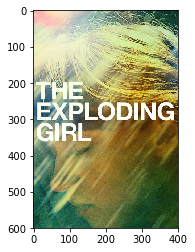

In [13]:
a_key_from_dict = list(posters_by_movie_id.items())[0][0]
plt.imshow(posters_by_movie_id[a_key_from_dict])
plt.show()

### Verify dimensions of all images

Only necessary for sanity check - about 10% of images do not have 600 pixels height but are all very close (farthest I could tell is around 560px)

In [14]:
EXPECTED_DIMENSION = '400x600'
def check_dimension(dimension):
    return dimension == EXPECTED_DIMENSION

def check_incorrect_dimensions():
    incorrect_dimensions = []

    for filename in poster_filenames:
        img_path = os.path.join(posters_dir, filename)
        output = subprocess.check_output(["file", img_path]).decode('utf-8')
        dimension = re.search('\d{3,4}x\d{3,4}', output)[0]
        if check_dimension(dimension) is False:
            incorrect_dimensions.append({ filename: dimension })
    return pd.Series(incorrect_dimensions)

# print(check_incorrect_dimensions())

### Check movies with missing posters

In [15]:
ids = movies.id.tolist()
missing_movies = []
for id in ids:
    if not str(id) in (test_movie_ids + train_movie_ids):
        missing_movies.append(id)
movies[movies.id.isin(missing_movies)]

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,movie_id,title_y,cast,crew,samuel,budget_original,popularity_original,vote_average_original,vote_count_original,revenue_original
2631,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,112430,"[{'id': 11162, 'name': 'miniseries'}]",en,The Company,Real-life figures from the Cold War era mix wi...,0.001696,[],...,112430,The Company,"[{'cast_id': 1, 'character': 'Jack McAuliffe',...","[{'credit_id': '5322a7959251411f770044a3', 'de...",False,0,1.485324,7.0,12,0
3285,0.0,"[{'id': 10770, 'name': 'TV Movie'}, {'id': 107...",NaN,153397,"[{'id': 470, 'name': 'spy'}, {'id': 6091, 'nam...",en,Restless,A young woman finds out that her mother worked...,0.000928,"[{""name"": ""British Broadcasting Corporation (B...",...,153397,Restless,"[{'cast_id': 3, 'character': 'Eva Delectorskay...","[{'credit_id': '52fe4b429251416c910d4bb7', 'de...",False,0,0.812776,4.9,8,0
3292,0.0,"[{'id': 18, 'name': 'Drama'}]",http://www.pbs.org/wgbh/masterpiece/wutheringh...,36597,"[{'id': 187056, 'name': 'woman director'}]",en,Wuthering Heights,Foundling Heathcliff is raised by the wealthy ...,0.005036,[],...,36597,Wuthering Heights,"[{'cast_id': 4, 'character': 'Heathcliff', 'cr...","[{'credit_id': '52fe45f79251416c910448eb', 'de...",False,0,4.409263,6.9,37,0
3510,0.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,183894,[],en,Emma,"Emma Woodhouse seems to be perfectly content, ...",0.002439,[],...,183894,Emma,"[{'cast_id': 3, 'character': 'Emma', 'credit_i...","[{'credit_id': '52fe4caf9251416c7512245b', 'de...",False,0,2.135689,7.6,38,0
3852,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,395766,"[{'id': 11162, 'name': 'miniseries'}]",en,The Secret,The Secret is the story of a real-life double ...,0.000048,[],...,395766,The Secret,"[{'cast_id': 0, 'character': '', 'credit_id': ...","[{'credit_id': '586756379251413e4c006618', 'de...",False,0,0.042346,0.0,0,0
3948,0.0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",NaN,50942,[],en,Creature,An amphibious shark-like monster terrorizes an...,0.003264,"[{""name"": ""MGM Television"", ""id"": 2230}, {""nam...",...,50942,Creature,"[{'cast_id': 1, 'character': 'Dr Simon Chase',...","[{'credit_id': '52fe47dcc3a36847f814c3d3', 'de...",False,0,2.857848,4.0,21,0
4118,0.0,[],NaN,325140,[],en,Hum To Mohabbat Karega,"Raju, a waiter, is in love with the famous TV ...",0.000001,[],...,325140,Hum To Mohabbat Karega,[],[],False,0,0.001186,0.0,0,0
4553,0.0,[],NaN,380097,[],en,America Is Still the Place,1971 post civil rights San Francisco seemed li...,0.000000,[],...,380097,America Is Still the Place,[],[],False,0,0.000000,0.0,0,0
4633,0.0,[],NaN,300327,[],en,Death Calls,An action-packed love story on the Mexican bor...,0.000007,[],...,300327,Death Calls,[],[],False,0,0.005883,0.0,0,0
4657,0.0,[],NaN,320435,[],en,UnDivided,UnDivided documents the true story of how a su...,0.000012,[],...,320435,UnDivided,[],[],False,0,0.010607,0.0,0,0
